In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import datetime as dt
import scipy
import sklearn

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

2024-06-17 08:20:52.860274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 08:20:52.860405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 08:20:53.010215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')
submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

In [4]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [5]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [8]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [9]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [12]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [13]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

train['dayofweek'] = train['datetime'].dt.dayofweek
####월, 요일, 시간, 분... 가져오기#####

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second

test['dayofweek'] = test['datetime'].dt.dayofweek
####월, 요일 ,시간, 분.... 가져오기######

<Axes: xlabel='year', ylabel='count'>

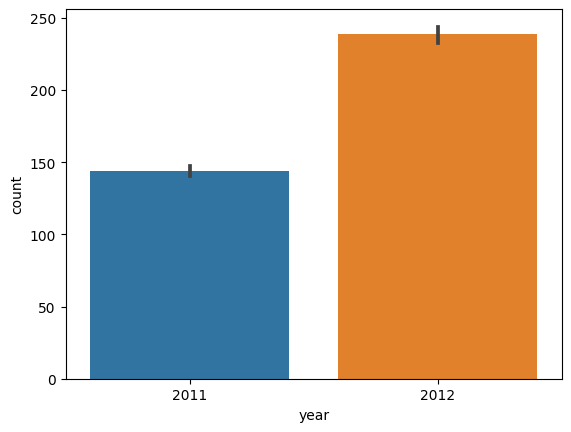

In [14]:
sns.barplot(data = train, x = 'year', y = 'count')

<Axes: xlabel='month', ylabel='count'>

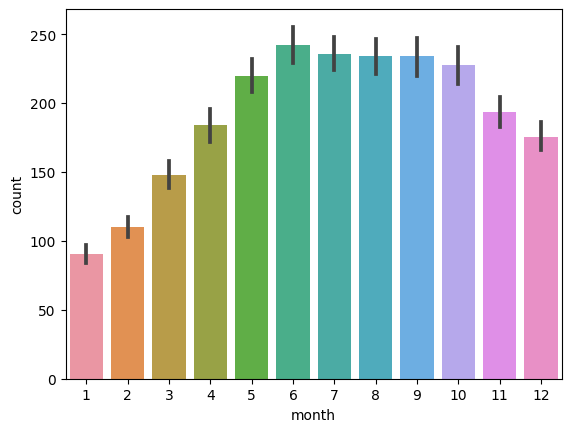

In [15]:
sns.barplot(data = train, x = 'month', y = 'count')

<Axes: xlabel='day', ylabel='count'>

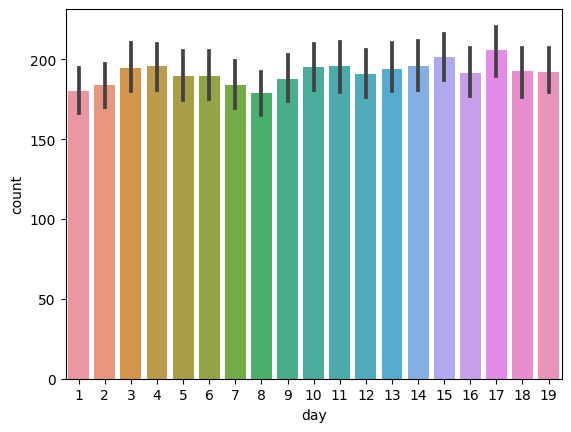

In [16]:
sns.barplot(data = train, x = 'day', y = 'count')

<Axes: xlabel='season', ylabel='count'>

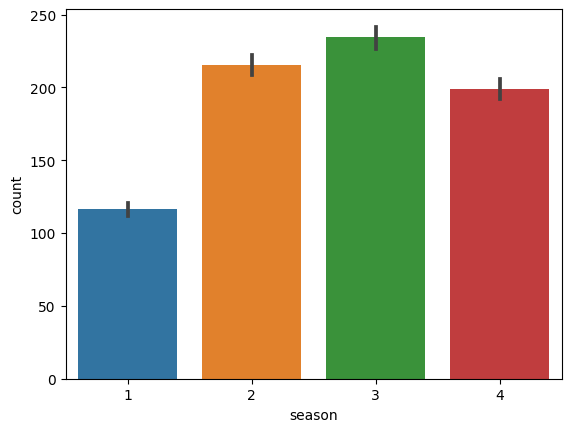

In [17]:
sns.barplot(data = train, x = 'season', y = 'count')

In [18]:
print(train[train['season'] == 1].month.unique())
print(train[train['season'] == 2].month.unique())
print(train[train['season'] == 3].month.unique())
print(train[train['season'] == 4].month.unique())

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


<Axes: xlabel='hour', ylabel='count'>

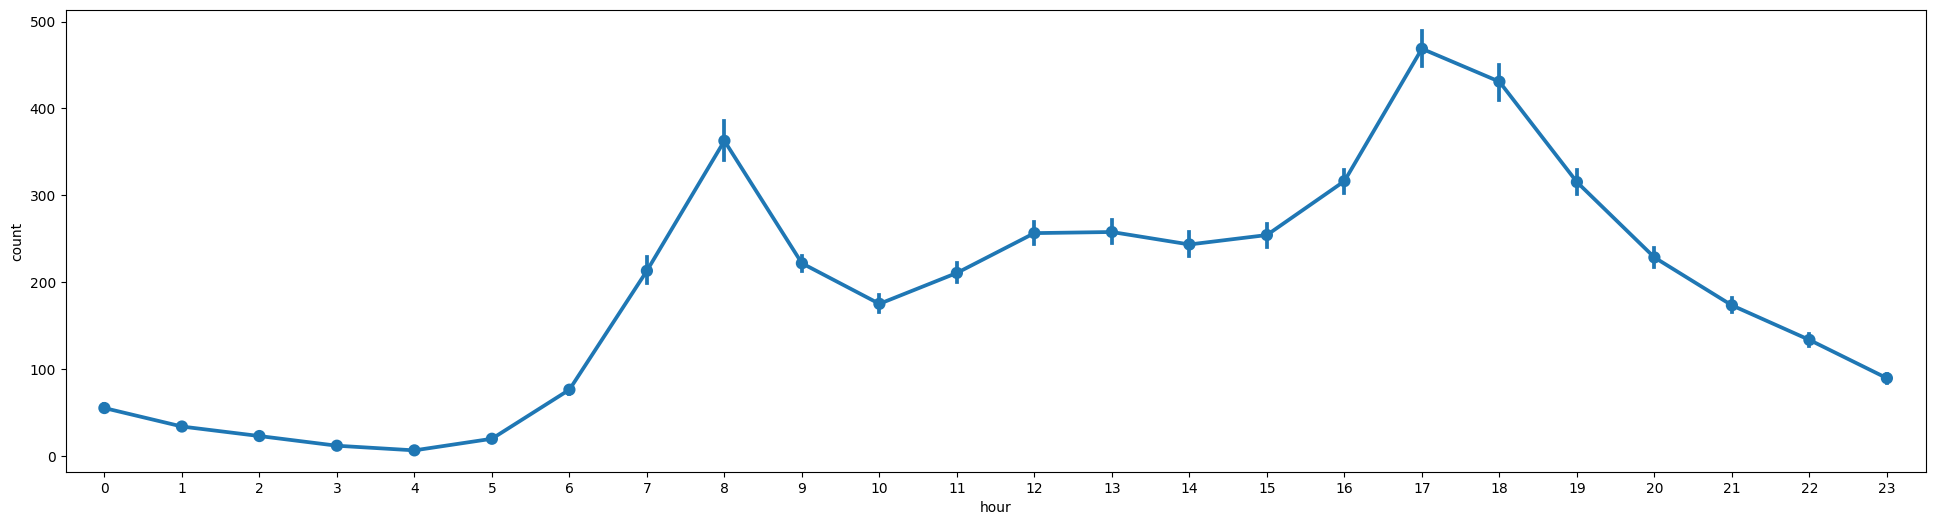

In [19]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

###PointPlot bar####
sns.pointplot(data=train, x='hour', y='count', ax=ax1)

<Axes: xlabel='hour', ylabel='count'>

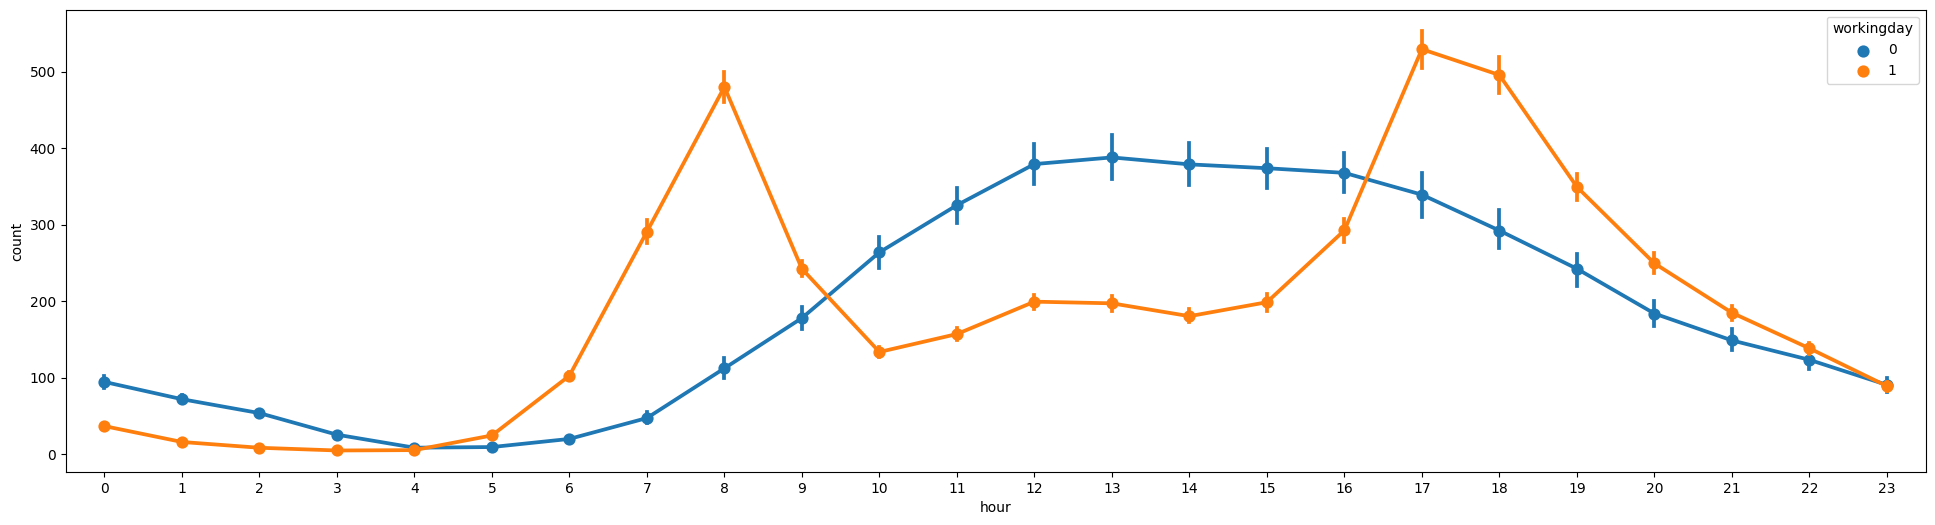

In [20]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'workingday', ax = ax1)

<Axes: xlabel='hour', ylabel='count'>

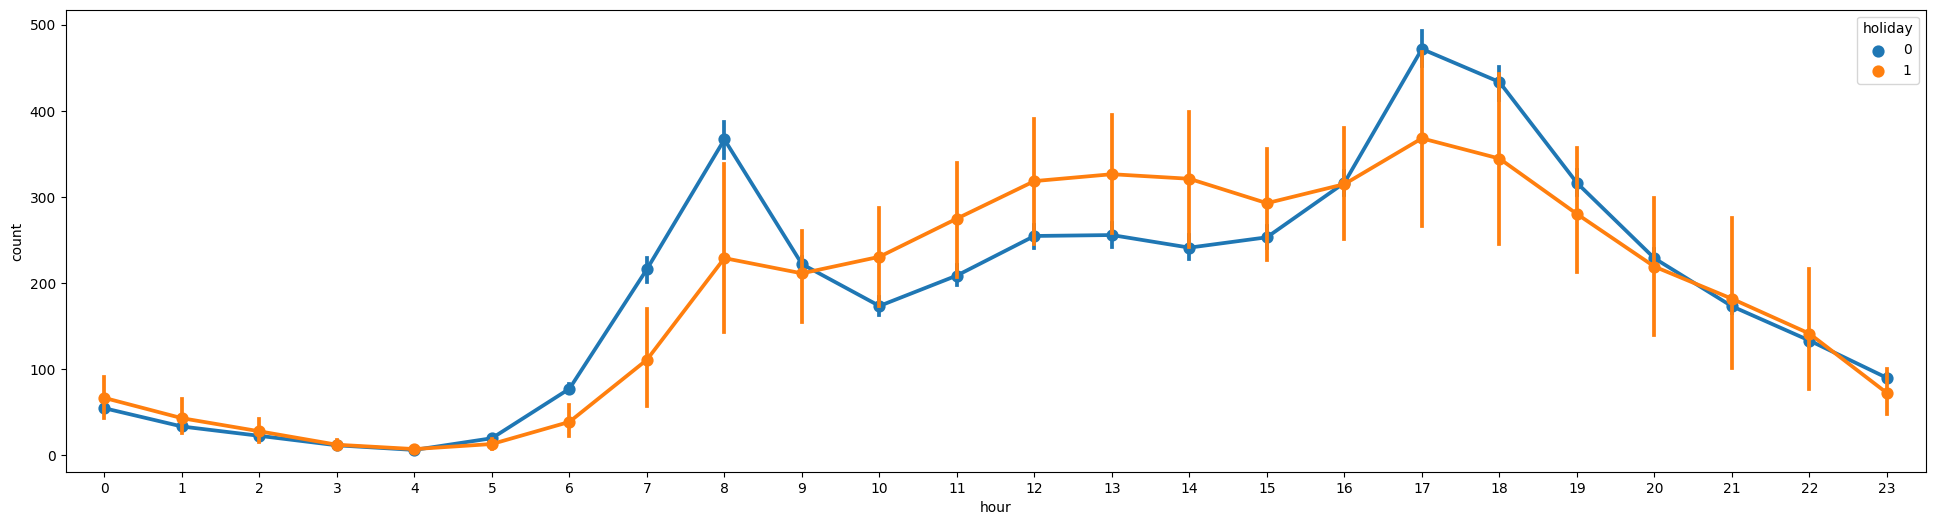

In [21]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'holiday', ax = ax1)

<Axes: xlabel='hour', ylabel='count'>

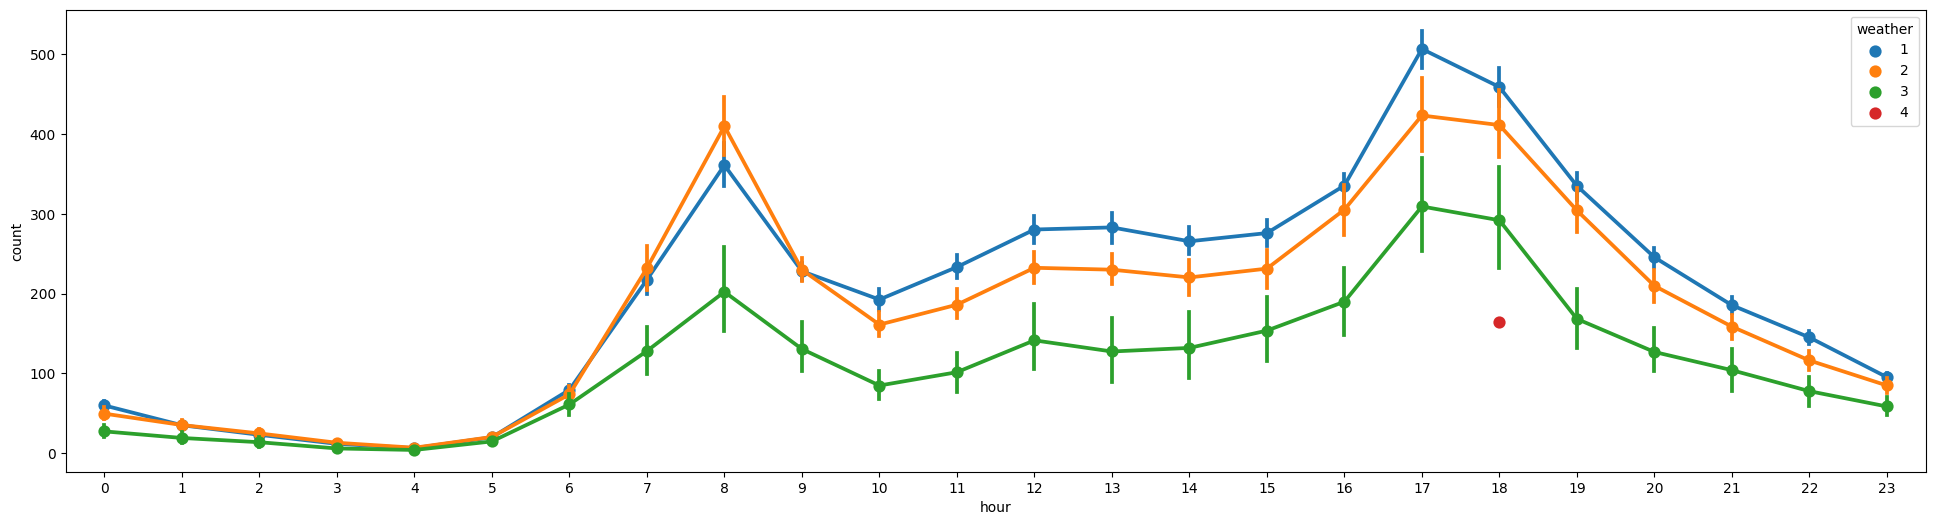

In [22]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'weather', ax = ax1)

<Axes: xlabel='hour', ylabel='count'>

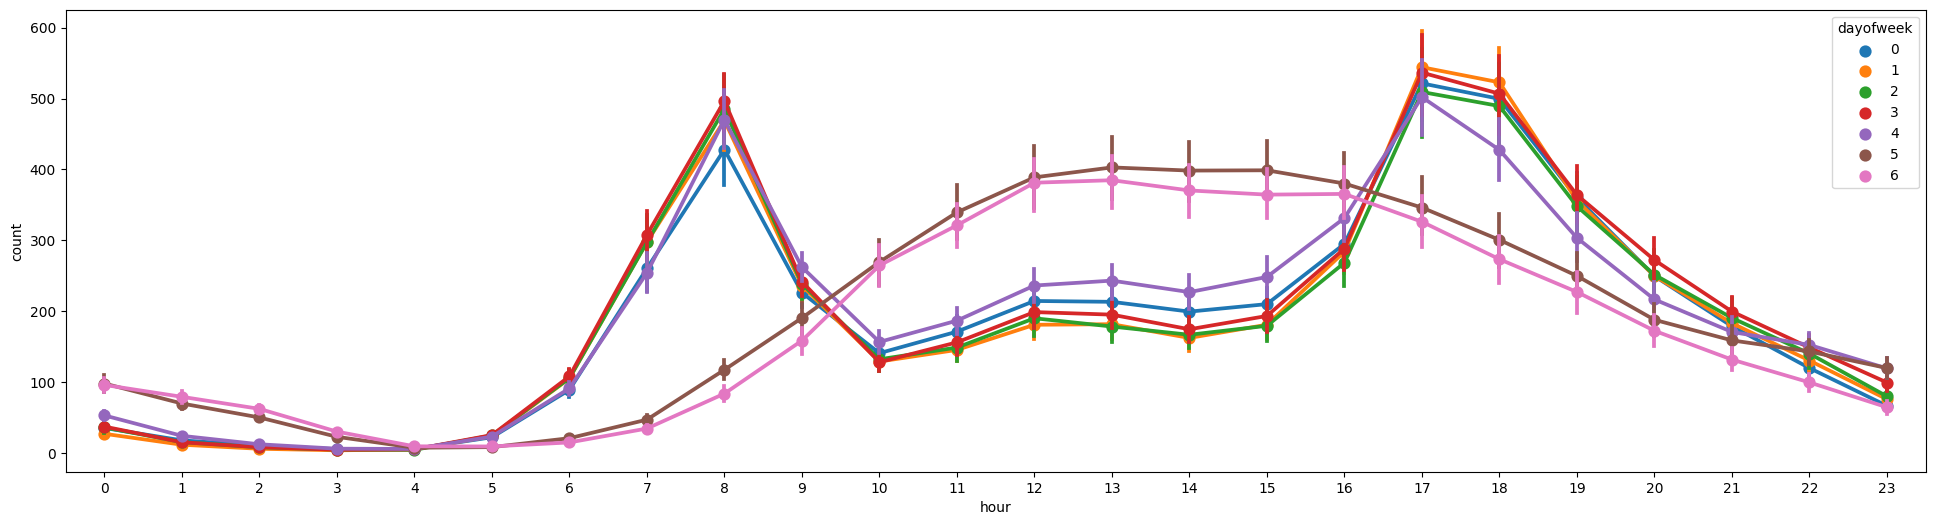

In [23]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

sns.pointplot(data = train, x = 'hour', y = 'count', hue = 'dayofweek', ax = ax1)

In [24]:
corr_data = pd.DataFrame({
    'datetime': [5, 5],
    'season': [106, 5],
    'holiday': [102, 0],
    'workingday': [102, 5],
    'weather': [106, 5],
    'temp': [149.56, 53.3],
    'atemp': [172.455, 64.395],
    'humidity': [493, 280],
    'windspeed': [102, 48.0055]
})

<Axes: >

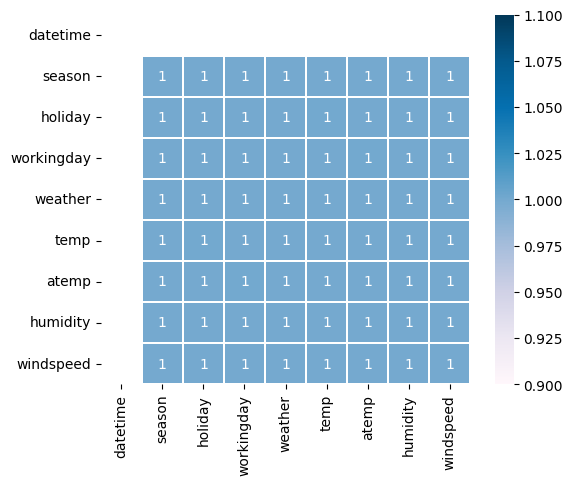

In [25]:
#히트맵 생성
colormap = plt.cm.PuBu
sns.heatmap(corr_data.corr()
            , linewidths = 0.1
            , square = True
            , annot = True
            , cmap = colormap)

<Axes: xlabel='datetime', ylabel='count'>

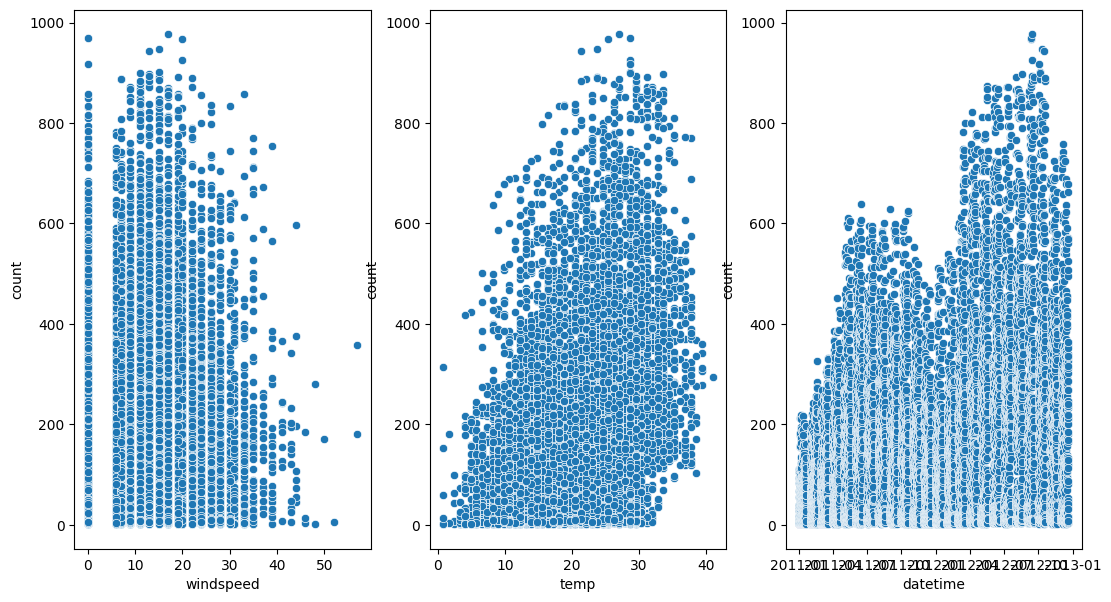

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (13, 7))

sns.scatterplot(data = train, x = 'windspeed', y = 'count', ax = ax1)
sns.scatterplot(data = train, x = 'temp', y = 'count', ax = ax2)
sns.scatterplot(data = train, x = 'datetime', y = 'count', ax = ax3)

In [27]:
len(train[train['windspeed'] == 0])

1313

<Axes: xlabel='count'>

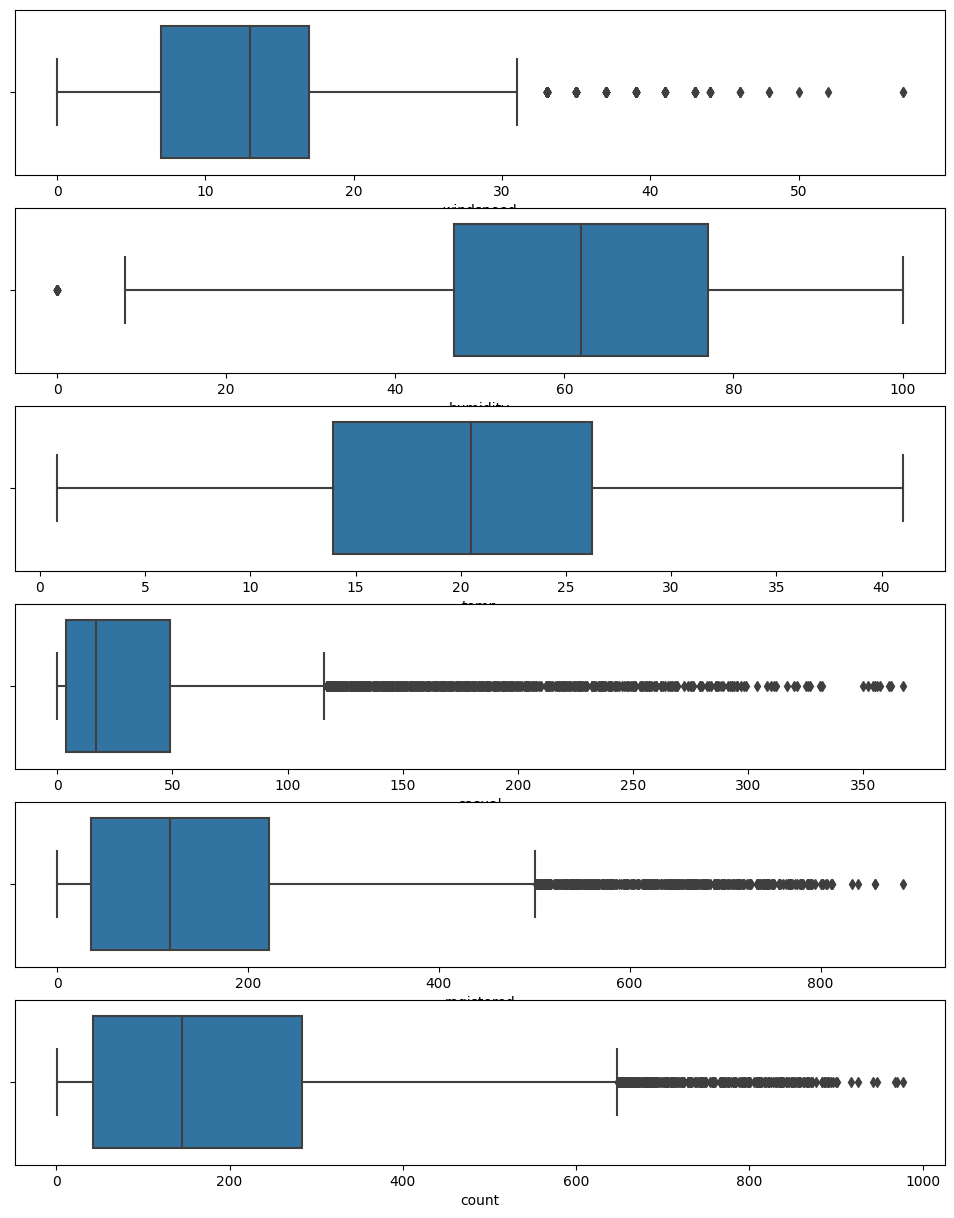

In [28]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (12, 15))

sns.boxplot(data = train, x = 'windspeed', ax = ax1)
sns.boxplot(data = train, x = 'humidity',ax = ax2)
sns.boxplot(data = train, x = 'temp', ax = ax3)
sns.boxplot(data = train, x = 'casual', ax = ax4)
sns.boxplot(data = train, x = 'registered', ax = ax5)
sns.boxplot(data = train, x = 'count', ax = ax6)

In [29]:
##이상치 제거####
from collections import Counter

def detect_outliers(data, n, cols):
    outlier_indices = []
    for col in cols:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]
    
    return multiple_outliers
    
Outliers_to_drop = detect_outliers(train, 2, ["temp", "atemp", "casual", "registered", "holiday", "windspeed", "count"])

In [30]:
train.shape

(10886, 19)

In [31]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)
train.shape

(10844, 19)

/tmp/ipykernel_19/2069270409.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  graph = sns.distplot(train['count']
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


skewness(왜도): 1.210848
kurtosis(첨도): 1.203062


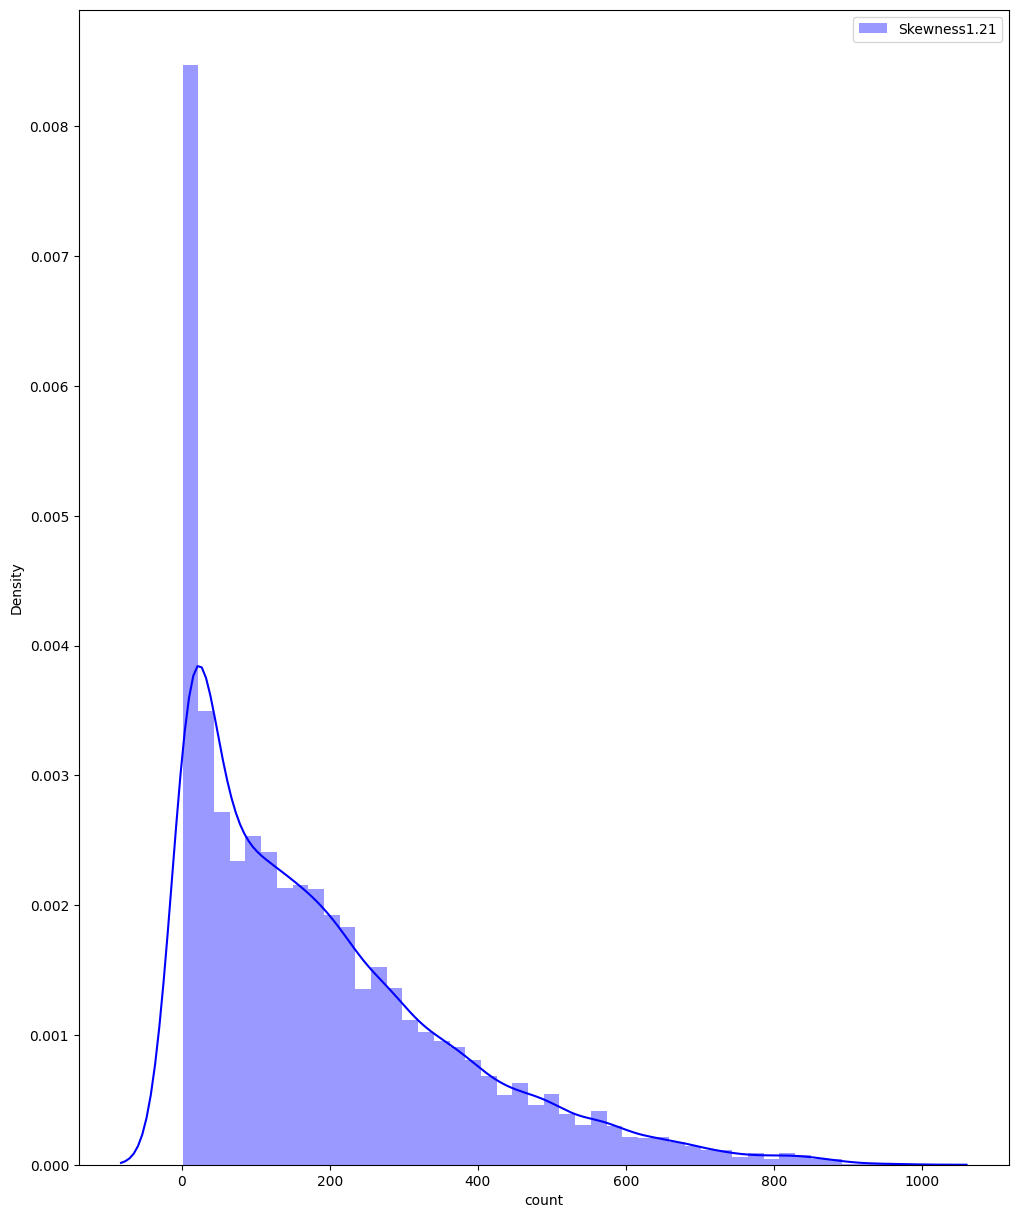

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (12, 15))
graph = sns.distplot(train['count']
                    , color = 'b'
                    , label = 'Skewness{:.2f}'.format(train['count'].skew())
                    , ax = ax)
                    
graph = graph.legend(loc = 'best')

print('skewness(왜도): %f' %train['count'].skew())
print('kurtosis(첨도): %f' %train['count'].kurt())

/tmp/ipykernel_19/3198548525.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  graph = sns.distplot(train['count_log']
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


skewness(왜도): -0.975300
kurtosis(첨도): 0.247431


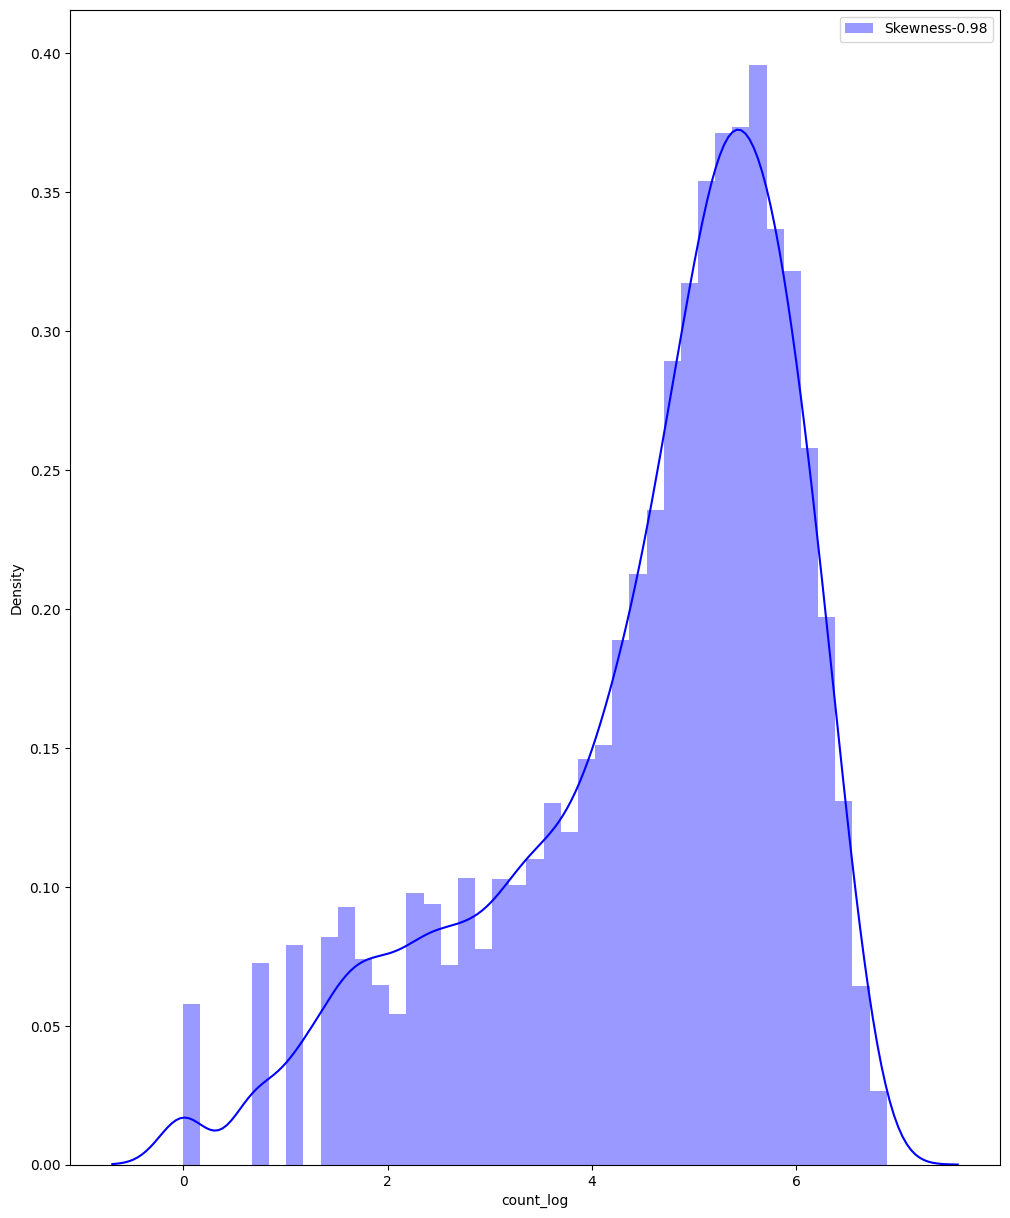

In [33]:
train['count_log'] = train['count'].map(lambda i : np.log(i) if i > 0 else 0 )

fig, ax = plt.subplots(1, 1, figsize = (12, 15))
graph = sns.distplot(train['count_log']
                    , color = 'b'
                    , label = 'Skewness{:.2f}'.format(train['count_log'].skew())
                    , ax = ax)
                    
graph = graph.legend(loc = 'best')

print('skewness(왜도): %f' %train['count_log'].skew())
print('kurtosis(첨도): %f' %train['count_log'].kurt())

train.drop('count', axis = 1, inplace= True)

In [34]:
def predict_windspeed(data) :
    wind0 = data.loc[data['windspeed'] == 0]
    windnot0 = data.loc[data['windspeed'] != 0]
    
    
    col = ['season', 'weather', 'temp', 'humidity', 'atemp', 'day']
    windnot0['windspeed'] = windnot0['windspeed'].astype('str')
    
    rf = RandomForestClassifier()
    
    rf.fit(windnot0[col], windnot0['windspeed'])
 
    
    pred_wind0 = rf.predict(wind0[col])
    
    
    wind0['windspeed'] = pred_wind0.astype(float)
    
    
    data = pd.concat([windnot0, wind0], ignore_index = True)
   
    return data

In [35]:
train = predict_windspeed(train)
test = predict_windspeed(test)

/tmp/ipykernel_19/1761479875.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windnot0['windspeed'] = windnot0['windspeed'].astype('str')
/tmp/ipykernel_19/1761479875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind0['windspeed'] = pred_wind0.astype(float)
/tmp/ipykernel_19/1761479875.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [36]:
train[train['windspeed'] == 0.0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,day,hour,minute,second,dayofweek,count_log


<Axes: xlabel='windspeed', ylabel='count'>

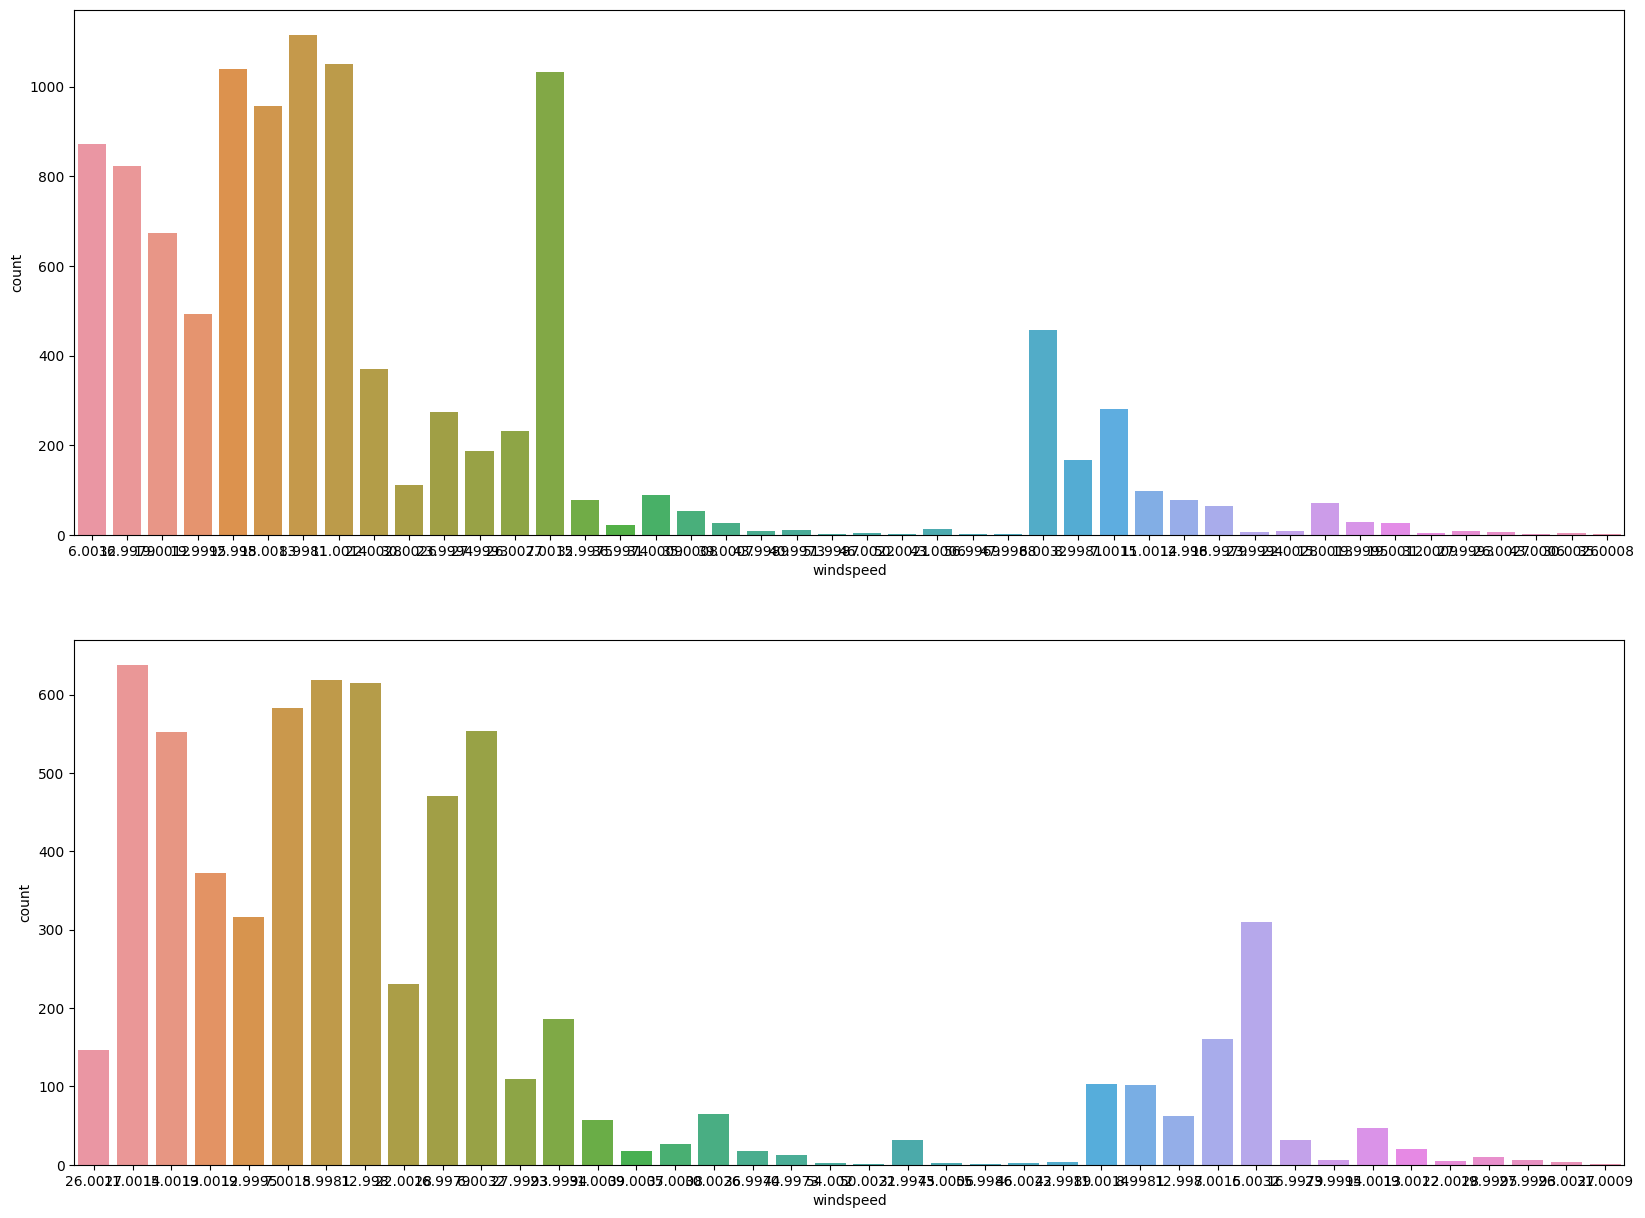

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(20, 15)

sns.countplot(data = train, x = 'windspeed', ax = ax1)
sns.countplot(data = test, x = 'windspeed', ax = ax2)

In [38]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'year',
       'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'count_log'],
      dtype='object')

In [39]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'dayofweek'],
      dtype='object')

In [40]:
train = pd.get_dummies(train, columns = ['weather'], prefix = 'weather')
test = pd.get_dummies(test, columns = ['weather'], prefix = 'weather')

train = pd.get_dummies(train, columns = ['season'], prefix = 'season')
test = pd.get_dummies(test, columns = ['season'], prefix = 'season')

train = pd.get_dummies(train, columns = ['holiday'], prefix = 'holiday')
test = pd.get_dummies(test, columns = ['holiday'], prefix = 'holiday')

In [41]:
train_datetime = train['datetime']
test_datetime = test['datetime']

train.drop(['datetime', 'workingday','atemp', 'minute', 'casual', 'registered', 'minute', 'second'], axis = 1, inplace = True) 
test.drop(['datetime', 'workingday','atemp', 'minute', 'second'], axis = 1, inplace = True) 

In [42]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

x_train = train.drop('count_log', axis = 1).values
target_label = train['count_log'].values
x_test = test.values
##########
x_train, x_val, y_train, y_val = train_test_split(x_train, target_label, test_size = 0.2, random_state = 2000)

In [43]:
train.columns

Index(['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek', 'count_log', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1'],
      dtype='object')

In [44]:
test.columns

Index(['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'dayofweek', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0',
       'holiday_1'],
      dtype='object')

In [45]:
x_test

array([[10.66, 56, '26.0027', ..., False, True, False],
       [10.66, 56, '11.0014', ..., False, True, False],
       [10.66, 56, '11.0014', ..., False, True, False],
       ...,
       [9.84, 87, 6.0032, ..., False, True, False],
       [10.66, 60, 31.0009, ..., False, True, False],
       [13.94, 61, 8.9981, ..., False, True, False]], dtype=object)

In [46]:
x_train

array([[26.24, 78, '7.0015', ..., False, True, False],
       [33.62, 46, '11.0014', ..., False, True, False],
       [13.12, 45, '16.9979', ..., True, True, False],
       ...,
       [22.96, 37, '19.0012', ..., False, True, False],
       [18.86, 63, '8.9981', ..., True, True, False],
       [17.22, 38, '19.9995', ..., False, True, False]], dtype=object)

In [47]:
x_val

array([[18.86, 82, '12.998', ..., True, True, False],
       [30.34, 51, '22.0028', ..., False, True, False],
       [12.3, 61, '6.0032', ..., True, True, False],
       ...,
       [25.42, 57, '19.9995', ..., False, True, False],
       [13.12, 70, '11.0014', ..., True, True, False],
       [26.24, 78, 7.0015, ..., False, True, False]], dtype=object)

In [48]:
y_train

array([5.14749448, 5.57215403, 5.68697536, ..., 5.01727984, 6.07073773,
       4.61512052])

In [49]:
y_val

array([5.79605775, 5.24702407, 4.69134788, ..., 6.32793678, 2.99573227,
       1.09861229])

In [50]:
regressor = GradientBoostingRegressor(n_estimators = 2000,
                                       learning_rate = 0.05,
                                       max_depth = 5,
                                       min_samples_leaf = 15,
                                       min_samples_split = 10,
                                       random_state = 42)
##
regressor.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=42)

In [51]:
score_train = regressor.score(x_train, y_train)
score_val = regressor.score(x_val, y_val)

print("train score : %f" %score_train)
print("Validation score : %f" %score_val)

train score : 0.986738
Validation score : 0.952473


In [52]:
pred = regressor.predict(x_test)

In [53]:
submission = pd.DataFrame()
submission['datetime'] = test_datetime
submission['count_log'] = pred

In [54]:
submission['count'] = np.exp(submission['count_log'])
submission.drop('count_log', axis = 1, inplace = True)
submission.head()

,datetime,count
0,2011-01-20 00:00:00,11.021671
1,2011-01-20 03:00:00,1.887252
2,2011-01-20 04:00:00,1.805790
3,2011-01-20 05:00:00,5.589141
4,2011-01-20 06:00:00,34.007006


In [55]:
submission.to_csv("Bike Sharing", index = False)